In [1]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='error', category=DataConversionWarning)

import pandas as pd
import psycopg2 as pg
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_samples,silhouette_score

In [2]:
# set up configuration
host = "localhost"
port = "5432"
database = "postgres"
user = "postgres"
password = "Jakarta12"
setting = "dbname=" + database + " user=" + user + " host=" + host + " port=" + port + " password=" + password
engine = pg.connect(setting)

In [34]:
query = f"""
	--select
    --    product_category_name
    --    , product_length_cm
    --    , product_height_cm
    --    , product_width_cm
	--from 
	--	olist_products_dataset_csv opdc 
        
        select 
			product_category_name ,cast(price as dec(19,2))price,freight_value
		from olist_products_dataset_csv a inner join olist_order_items_dataset_csv b on a.product_id =b.product_id 
    """
df_read = pd.read_sql(query, con=engine)

In [35]:
df_read

,product_category_name,price,freight_value
0,cool_stuff,58.90,13.29
1,pet_shop,239.90,19.93
2,moveis_decoracao,199.00,17.87
3,perfumaria,12.99,12.79
4,ferramentas_jardim,199.90,18.14
...,...,...,...
112645,utilidades_domesticas,299.99,43.41
112646,informatica_acessorios,350.00,36.53
112647,esporte_lazer,99.90,16.95
112648,informatica_acessorios,55.99,8.72


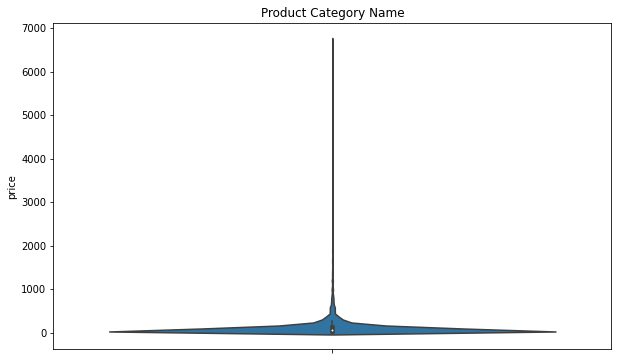

In [37]:
plt.figure(figsize=(10,6))
plt.title("Product Category Name")
sns.axes_style("dark")
sns.violinplot(y=df_read["price"])
plt.show()

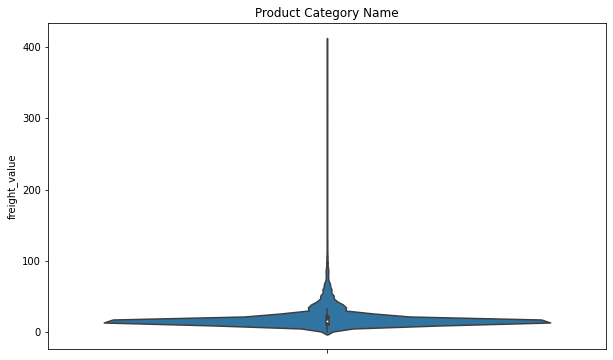

In [38]:
plt.figure(figsize=(10,6))
plt.title("Product Category Name")
sns.axes_style("dark")
sns.violinplot(y=df_read["freight_value"])
plt.show()

In [40]:
products = df_read.groupby('product_category_name').count()[1:]['price']

In [41]:
products = pd.DataFrame(products).sort_values('price').reset_index()[::-1][:10]

In [44]:
df_train = df_read[(df_read.price >=10) & (df_read.freight_value >=1)]

In [45]:
df_train

,product_category_name,price,freight_value
0,cool_stuff,58.90,13.29
1,pet_shop,239.90,19.93
2,moveis_decoracao,199.00,17.87
3,perfumaria,12.99,12.79
4,ferramentas_jardim,199.90,18.14
...,...,...,...
112645,utilidades_domesticas,299.99,43.41
112646,informatica_acessorios,350.00,36.53
112647,esporte_lazer,99.90,16.95
112648,informatica_acessorios,55.99,8.72


In [46]:
df_train.iloc[:,1:]

,price,freight_value
0,58.90,13.29
1,239.90,19.93
2,199.00,17.87
3,12.99,12.79
4,199.90,18.14
...,...,...
112645,299.99,43.41
112646,350.00,36.53
112647,99.90,16.95
112648,55.99,8.72


### ELBOW METHODE

In [50]:
start_loop = datetime.datetime.now()
wcss = []
for k in range(1,20):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(df_train.iloc[:,1:])
    wcss.append(kmeans.inertia_)
stop_loop = datetime.datetime.now()
print("[Total Run Time]:", (stop_loop - start_loop).seconds)

[Total Run Time]: 52


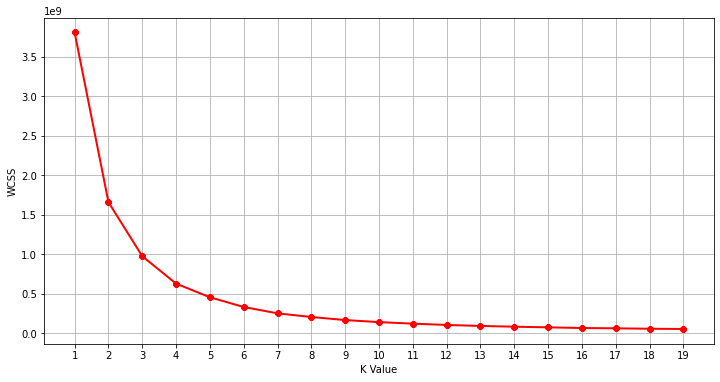

In [51]:
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(1,20),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,20,1))
plt.ylabel("WCSS")
plt.show()

In [52]:
km = KMeans(n_clusters=5)
clusters = km.fit_predict(df_train.iloc[:,1:])
df_train["label"] = clusters

C:\Users\jilli\AppData\Local\Temp\ipykernel_22764\3228651075.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["label"] = clusters


In [53]:
df_train

,product_category_name,price,freight_value,label
0,cool_stuff,58.90,13.29,3
1,pet_shop,239.90,19.93,0
2,moveis_decoracao,199.00,17.87,0
3,perfumaria,12.99,12.79,3
4,ferramentas_jardim,199.90,18.14,0
...,...,...,...,...
112645,utilidades_domesticas,299.99,43.41,0
112646,informatica_acessorios,350.00,36.53,2
112647,esporte_lazer,99.90,16.95,3
112648,informatica_acessorios,55.99,8.72,3


In [54]:
df_train.groupby('label').count()

,product_category_name,price,freight_value
label,,,
0,28982,28982,28982
1,1385,1385,1385
2,5084,5084,5084
3,75170,75170,75170
4,319,319,319


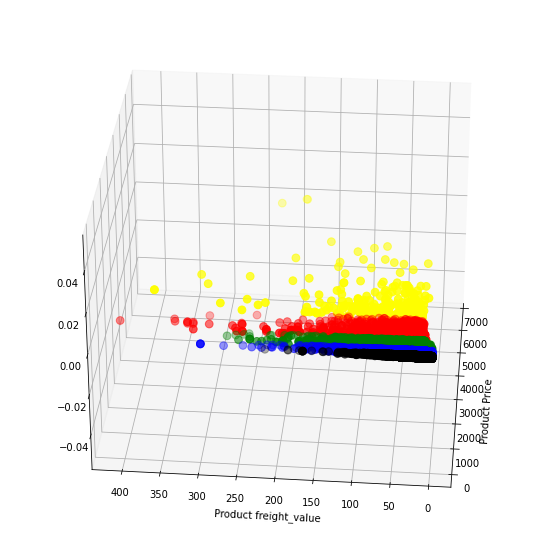

In [56]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_train.price[df_train.label == 0], df_train.freight_value[df_train.label == 0], c='blue', s=60)
ax.scatter(df_train.price[df_train.label == 1], df_train.freight_value[df_train.label == 1], c='red', s=60)
ax.scatter(df_train.price[df_train.label == 2], df_train.freight_value[df_train.label == 2], c='green', s=60)
ax.scatter(df_train.price[df_train.label == 3], df_train.freight_value[df_train.label == 3], c='black', s=60)
ax.scatter(df_train.price[df_train.label == 4], df_train.freight_value[df_train.label == 4], c='yellow', s=60)
ax.view_init(30, 185)
plt.xlabel("Product Price")
plt.ylabel("Product freight_value")
#ax.set_zlabel('Product Width Cm')
plt.show()

### SILHOUETTE COEFFICIENT

In [ ]:
start_loop = datetime.datetime.now()
with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
    warnings.filterwarnings('error')
    silhoutte_result = {}
    
    for n_clusters in range(2,50):
        
        try:
            clusterer = KMeans(n_clusters=n_clusters)
            preds = clusterer.fit_predict(df_train.iloc[:,1:4])
            
            centers = clusterer.cluster_centers_
            
            score = silhouette_score(df_train.iloc[:,1:4],preds)
            
            silhoutte_result.update({n_clusters: score})
        except Warning:
            print("[Convergence Warning] : ", n_clusters)
            break
stop_loop = datetime.datetime.now()
print("[Total Run Time]:", (stop_loop - start_loop).seconds)

In [ ]:
max(silhoutte_result, key=silhoutte_result.get)

In [ ]:
km = KMeans(n_clusters=49)
clusters = km.fit_predict(df_train.iloc[:,1:])
df_train["label_2"] = clusters

<ipython-input-43-575531b56b1f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["label_2"] = clusters


In [ ]:
df_train

,product_category_name,product_length_cm,product_height_cm,product_width_cm,label,label_2
46,cool_stuff,47.0,40.0,47.0,2,46
79,agro_industria_e_comercio,63.0,66.0,56.0,0,40
85,instrumentos_musicais,55.0,40.0,40.0,1,16
148,automotivo,50.0,50.0,50.0,1,11
157,beleza_saude,40.0,40.0,40.0,2,0
...,...,...,...,...,...,...
32714,moveis_decoracao,45.0,40.0,45.0,2,46
32759,eletrodomesticos,50.0,50.0,50.0,1,11
32811,ferramentas_jardim,50.0,50.0,50.0,1,11
32832,moveis_decoracao,42.0,100.0,42.0,4,3
